In [1]:
import os
datadir = '../datasets/kaggle/the-simpsons-characters-dataset/'
os.listdir(datadir)

['annotation.txt',
 'characters_illustration.png',
 'kaggle_simpson_testset',
 'number_pic_char.csv',
 'simpsons_dataset',
 'weights.best.hdf5']

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
datagen = ImageDataGenerator( 
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    rotation_range=40,
    zoom_range = 0.1,
    rescale=1./255,
    validation_split=0.33)

In [4]:
train_generator = datagen.flow_from_directory(
    datadir+'simpsons_dataset',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="training")
valid_generator = datagen.flow_from_directory(
    directory=datadir+'simpsons_dataset',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="validation"
)

Found 14048 images belonging to 42 classes.
Found 6885 images belonging to 42 classes.


### Training

In [5]:
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [7]:
from keras.applications import xception

In [8]:
base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
out = Dense(42, activation='softmax')(x)

model = Model(base_model.input, out)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [11]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                    verbose=1,
                    callbacks=[learning_rate_reduction]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
878/878 [==============================] - 309s 352ms/step - loss: 1.6239 - acc: 0.5974 - val_loss: 4.3937 - val_acc: 0.5628
Epoch 2/20
878/878 [==============================] - 299s 340ms/step - loss: 0.9001 - acc: 0.7928 - val_loss: 4.1734 - val_acc: 0.5464
Epoch 3/20
878/878 [==============================] - 447s 509ms/step - loss: 0.7340 - acc: 0.8312 - val_loss: 2.3600 - val_acc: 0.6736
Epoch 4/20
878/878 [==============================] - 446s 508ms/step - loss: 0.6443 - acc: 0.8536 - val_loss: 1.6114 - val_acc: 0.8006
Epoch 5/20
878/878 [==============================] - 450s 512ms/step - loss: 0.6017 - acc: 0.8645 - val_loss: 4.9878 - val_acc: 0.6097
Epoch 6/20
878/878 [==============================] - 452s 515ms/step - loss: 0.5355 - acc: 0.8795 - val_loss: 1.4908 - val_acc: 0.8020
Epoch 7/20
878/878 [==============================] - 473s 539ms/step - loss: 0.5469 - acc: 0.8836 - val_loss: 0.7449 - val_acc: 0.8696


### VAL_ACC = 0.92

### Test

In [12]:
from keras.preprocessing.image import img_to_array, load_img
import numpy as np

In [14]:
indicer = dict([(v,k) for k,v in train_generator.class_indices.items()])

In [31]:
def img_preprocess(img):
    img_arr = img_to_array(img).reshape((1,224,224,3))
    img_arr /= 255.
    return img_arr

I think this character is....apu_nahasapeemapetilon!


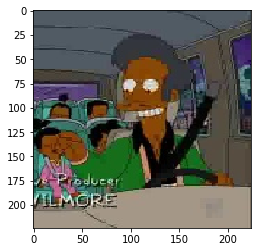

In [71]:
testdir = datadir+'kaggle_simpson_testset/'
img = load_img(testdir+'apu_nahasapeemapetilon/apu_nahasapeemapetilon_8.jpg', target_size=(224,224))
plt.imshow(img)
print('I think this character is....%s!'%indicer[np.argmax(model.predict(img_preprocess(img)),axis=1).item()])

In [44]:
labels = set(map(lambda x: '_'.join(x.split('_')[:-1]), os.listdir(testdir)))

In [64]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=testdir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 990 images belonging to 42 classes.


In [66]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n//test_generator.batch_size)

In [67]:
print('test loss : %s / test accuracy : %s'%(test_loss, test_acc))

test loss : 0.5228443816333381 / test accuracy : 0.9509394572025052


### TEST_ACC = 0.95

In [72]:
model.save_weights('../saved_model/simpsons_classifier_xception.h5')